In [34]:
%matplotlib inline
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.interpolate import interp1d
from scipy.stats import stats
import itertools

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier

#labels
dfAll = pd.read_csv('./../out/Allevent.txt',encoding='utf-16',index_col=0)
eventLabel=pd.DataFrame()
eventLabel['eventidx']=dfAll.index
eventLabel['valence']=dfAll['valence'].map(lambda x: 1 if x >0 else 0)
eventLabel['arousal']=dfAll['arousal'].map(lambda x: 1 if x >1 else 0)
eventLabel.set_index('eventidx',inplace=True)

eventLabel['event']=dfAll['event']

eventdf=pd.get_dummies(dfAll.event)
emodf=pd.get_dummies(dfAll.emotions)

eventLabel=pd.concat([eventLabel,emodf],axis=1)
eventLabel.head()

,valence,arousal,event,colere,ennui,fierte,frustration,joie,neutre,peur
eventidx,,,,,,,,,,
0,0,1,rate,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0,1,arret du gardien,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,but,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,tir,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,1,arret du gardien,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [2]:
phyEventdf10=pd.read_csv('./../out/feature/phyEvent10s.csv',encoding='utf-16',index_col='eventidx')
phyEventdf14=pd.read_csv('./../out/feature/phyEvent14s.csv',encoding='utf-16',index_col='eventidx')
phyEventdf20=pd.read_csv('./../out/feature/phyEvent20s.csv',encoding='utf-16',index_col='eventidx')
phyEventdf30=pd.read_csv('./../out/feature/phyEvent30s.csv',encoding='utf-16',index_col='eventidx')

dfLens=[phyEventdf10,phyEventdf14,phyEventdf20,phyEventdf30]
(featureTrans10,featureTrans14,featureTrans20,featureTrans30)=[df.groupby('sujet').transform(lambda x: (x - x.mean()) / x.std()) for df in dfLens]

phyEventNormdf10=pd.concat([phyEventdf10['sujet'], featureTrans10], axis=1)
phyEventNormdf14=pd.concat([phyEventdf14['sujet'], featureTrans14], axis=1)
phyEventNormdf20=pd.concat([phyEventdf20['sujet'], featureTrans20], axis=1)
phyEventNormdf30=pd.concat([phyEventdf30['sujet'], featureTrans30], axis=1)

phyEventNormdf10n=phyEventNormdf10.dropna(axis=1,how='any')
phyEventNormdf14n=phyEventNormdf14.dropna(axis=1,how='any')
phyEventNormdf20n=phyEventNormdf20.dropna(axis=1,how='any')
phyEventNormdf30n=phyEventNormdf30.dropna(axis=1,how='any')

DF={'10s':phyEventNormdf10n,
     '14s':phyEventNormdf14n,
     '20s':phyEventNormdf20n,
     '30s':phyEventNormdf30n}

selectfa=np.load("../out/selectedfeaturearousal.npy")
selectfv=np.load("../out/selectedfeaturevalence.npy")

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score,KFold
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.dummy import DummyClassifier
import pickle

X=phyEventNormdf20n

names = ["DummyClassifier", "Linear SVM"]
classifiers = [
    DummyClassifier(strategy='most_frequent',random_state=0),
    SVC(kernel="linear", C=1)]


Xn=X.dropna(axis=1,how='any')
Xn_s=Xn[list(set(selectfa) & set(X.columns.values))]
y_all=eventLabel.ix[18:,:]
y=y_all.loc[:,'arousal']

kf = KFold(n_splits=10,shuffle=True)
i=0
clfls=[None] * 10
score=[None] * 10
diff01= pd.DataFrame(np.zeros((1730, 10)),columns=range(10),index=Xn_s.index)
diff10= pd.DataFrame(np.zeros((1730, 10)),columns=range(10),index=Xn_s.index)
diff= pd.DataFrame(np.zeros((1730, 10)),columns=range(10),index=Xn_s.index)
for train, test in kf.split(Xn_s):
    print(train,test)
    res=pd.DataFrame()
    #print(train,test)
    X_train, X_test, y_train, y_test = Xn_s.iloc[train], Xn_s.iloc[test], y.iloc[train], y.iloc[test]
    clf=SVC(kernel="linear", C=1).fit(X_train, y_train) 
    pre=clf.predict(X_test)
    score[i]=clf.score(X_test, y_test)
    res['real']=y_test
    res['pre']=pre
    error=(res['real']!=res['pre'])
    idx=error[error==True].index
    error01=(res['real']==0) & (res['pre']==1)
    idx01=error01[error01==True].index
    error10=(res['real']==1) & (res['pre']==0)
    idx10=error10[error10==True].index
    diff.loc[idx,i]=1
    diff01.loc[idx01,i]=1
    diff10.loc[idx10,i]=1
    #clfls[i] = pickle.dumps(clf)
    i=i+1
    

    #print("{0:.3f} (std: {1:.3f})".format(scores.mean(),np.std(scores)))

(array([   0,    1,    2, ..., 1726, 1727, 1729]), array([  19,   23,   25,   43,   48,   81,   86,   87,  101,  118,  119,
        128,  138,  153,  164,  176,  185,  189,  207,  213,  237,  238,
        256,  275,  278,  279,  289,  292,  325,  330,  338,  346,  347,
        348,  350,  364,  375,  383,  384,  386,  396,  401,  414,  418,
        422,  456,  458,  462,  478,  488,  491,  493,  499,  519,  524,
        539,  559,  564,  605,  608,  624,  631,  640,  643,  644,  648,
        678,  681,  686,  687,  690,  710,  717,  718,  745,  747,  748,
        752,  758,  764,  772,  774,  778,  795,  810,  828,  837,  839,
        844,  864,  869,  871,  876,  901,  911,  923,  928,  932,  949,
        956,  958,  963,  964,  988,  996, 1012, 1013, 1019, 1064, 1067,
       1073, 1081, 1087, 1096, 1104, 1129, 1135, 1150, 1151, 1205, 1208,
       1212, 1226, 1241, 1248, 1270, 1278, 1280, 1283, 1294, 1296, 1302,
       1325, 1336, 1349, 1355, 1374, 1384, 1411, 1422, 1445, 1456, 1461,


In [147]:
tmp=diff.sum(axis=1)
np.sum(tmp==0)
tmp=pd.DataFrame(tmp).join(dfAll)

In [140]:
tmp.head()

,0,sujet,match,Absolute_sec,event,emotions,arousal,valence
eventidx,,,,,,,,
18,0.0,2,1,38404,arret du gardien,frustration,2.0,-3.0
19,1.0,2,1,38495,arbitrage,colere,2.0,-1.0
20,0.0,2,1,38613,tir,peur,3.0,2.0
21,0.0,2,1,38851,rate,frustration,0.0,-1.0
22,1.0,2,1,38880,rate,frustration,2.0,-2.0


In [150]:
d=tmp.groupby('arousal')[0].count()

In [151]:
u=tmp.groupby('arousal')[0].sum()

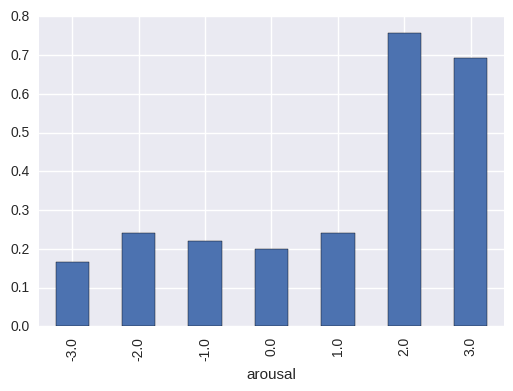

In [156]:
(u/d).plot(kind='bar')

In [142]:
tmp.groupby('arousal')[0].sum()

arousal
-3.0      0.0
-2.0      0.0
-1.0      0.0
 0.0      0.0
 1.0      0.0
 2.0    385.0
 3.0    221.0
Name: 0, dtype: float64

In [144]:
tmp.groupby('arousal')[0].sum()

arousal
-3.0      4.0
-2.0     19.0
-1.0     25.0
 0.0     49.0
 1.0    112.0
 2.0      0.0
 3.0      0.0
Name: 0, dtype: float64

# dist malclassé

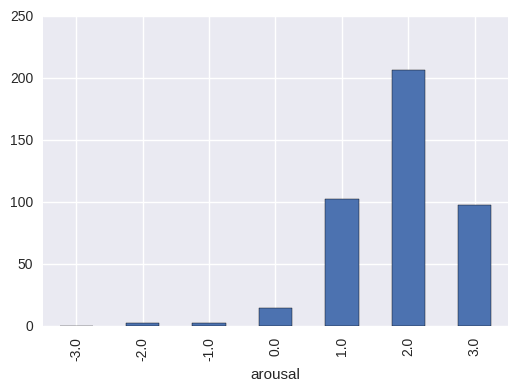

In [25]:
tmp.groupby('arousal')[0].sum().plot(kind='bar')

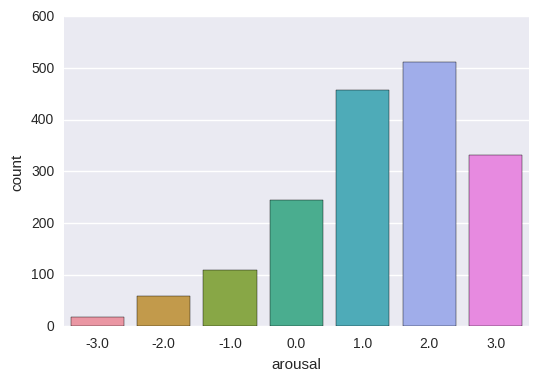

In [131]:

ax = sns.countplot(x="arousal",data=tmp)

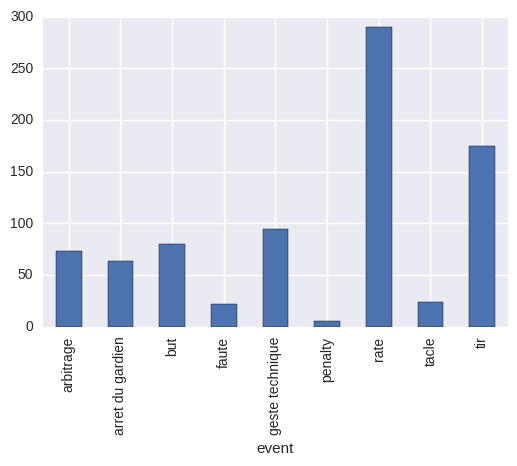

In [136]:
tmp.groupby('event')[0].sum().plot(kind='bar')

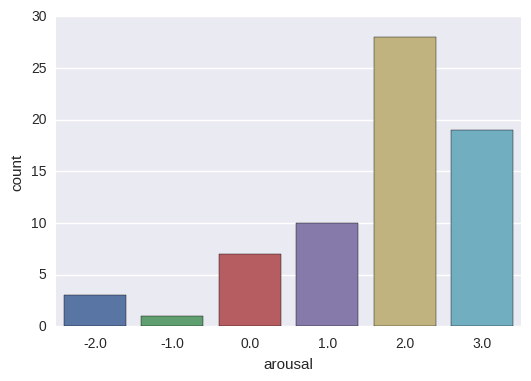

In [74]:
com=res.join(dfAll)
tmp=com[res['real']!=res['pre']]
ax = sns.countplot(x="arousal",data=tmp)

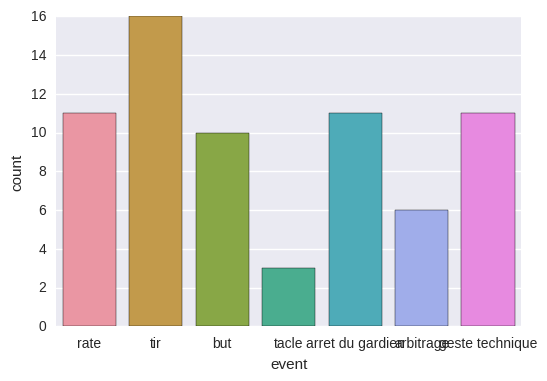

In [76]:
ax = sns.countplot(x="event",data=tmp)

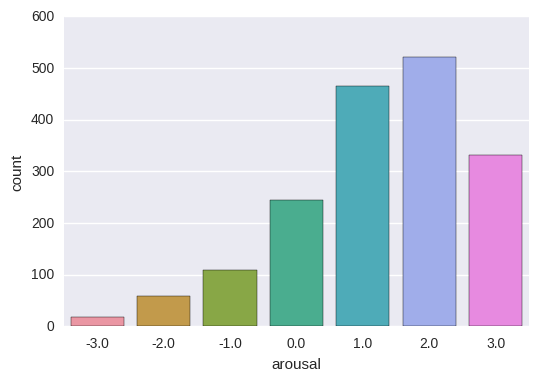

In [71]:
ax = sns.countplot(x="arousal",data=dfAll)

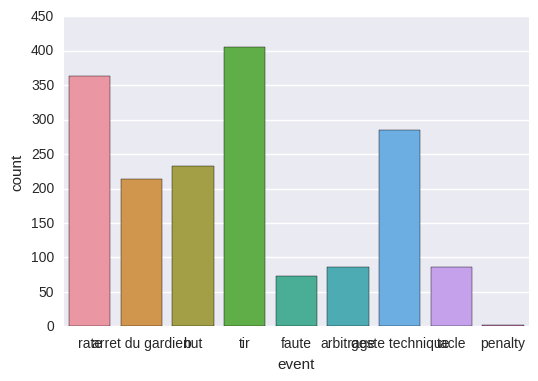

In [75]:
ax = sns.countplot(x="event",data=dfAll)

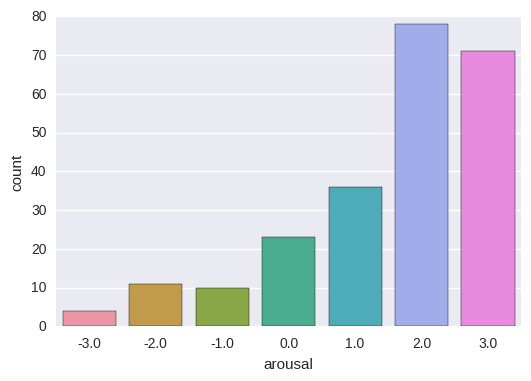

In [142]:
dfbut=dfAll[dfAll['event']=='but']
ax = sns.countplot(x="arousal",data=dfbut)

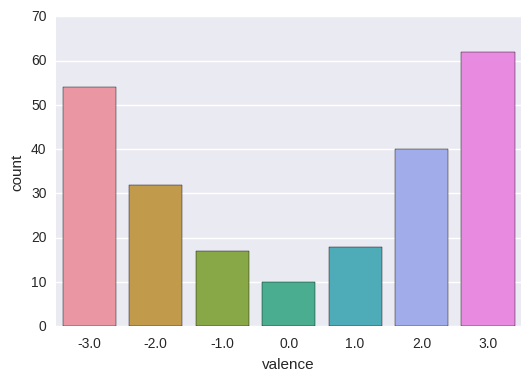

In [143]:
ax = sns.countplot(x="valence",data=dfbut)

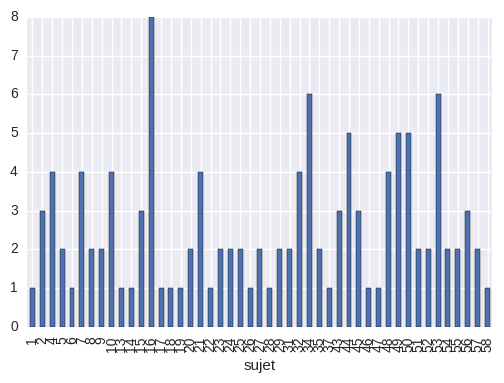

In [147]:
#but pour
dfbut[dfbut['valence']>0].groupby('sujet')['event'].count().plot(kind='bar')

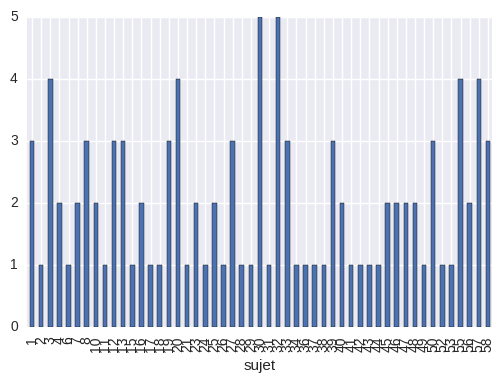

In [148]:
#contre
dfbut[dfbut['valence']<0].groupby('sujet')['event'].count().plot(kind='bar')

In [182]:
def get_sec(row,col):
    s=row[col]
    l = s.split(':')
    return int(l[0]) * 3600 + int(l[1]) * 60 + int(l[2])

Mdf={}
Datapath='./../Matchjrn/'
Matchfilepath='./../biopacMatch/'
Biofilepath="./../biopac/"
biofilelist=[]
for fn in os.listdir(Biofilepath):
    biofilelist.append(fn)

num=0
for fn in os.listdir(Datapath):
    num=num+1
    sujet = re.split(r'\s*[.\-\s]\s*', fn)[1]  # M - S2.csv
    #print num, sujet
    matchfile = Datapath + fn
    #print matchfile
    Mdfname=sujet
    df=pd.read_csv(matchfile,sep=',',header=None,index_col=0)
    df[3]=df.apply (lambda row: get_sec(row,1),axis=1)
    df[4]=df.apply (lambda row: get_sec(row,2),axis=1)
    df[5]=df[4]-df[3]
    df=df.loc[['base0','en1','en2','base1','m11','m12','base2','m21','m22','base3','m31','m32'],:]
    df.loc[['base0','base1','base2','base3'],6]=df.loc[:,4]-180
    df.loc[['en1','en2','m11','m12','m21','m22','m31','m32'],6]=df.loc[:,4]-240
    df[6]=df[6].astype(int)
    #df_o=df[[6,4]]
    Mdf[Mdfname]=df
Mdf

In [150]:
dfbut['pour']=dfbut['valence'].map(lambda x: 1 if x>0 else 0)

/home/wenlu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [151]:
dfbut.head()

,sujet,match,Absolute_sec,event,emotions,arousal,valence,pour
2,1,1,47852,but,colere,2.0,-3.0,0
8,1,2,50049,but,colere,2.0,-2.0,0
10,1,3,51270,but,peur,1.0,-1.0,0
14,1,3,51732,but,fierte,2.0,2.0,1
42,2,2,41023,but,colere,3.0,-3.0,0


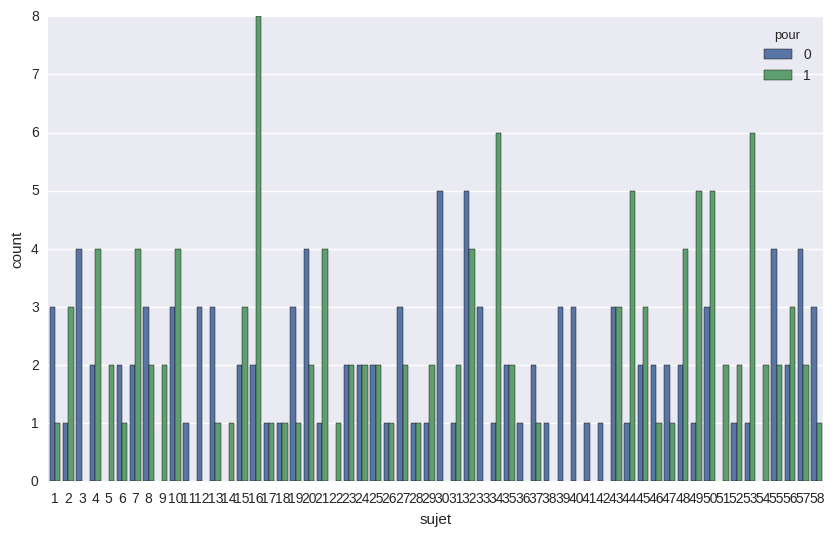

In [156]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="sujet",hue='pour',data=dfbut)

In [177]:
ls=list(set(Xn_s.index)&set(dfbut.index))
ls.sort()

In [179]:
Xn_s.loc[ls]

,EDA_tonic_max,sfEMG_one_ct,EDA_ph_avgder,EDA_ph_var,EDA_tonic_maxgra,sfEMG_raw_max,ECG_raw_stddev,EDA_phde_stddev,EDA_phde_vrange,EDA_raw_avgder,EDA_raw_median,EDA_tonic_avgder,EDA_tonic_min,ECG_fre_b1,EDA_tonic_absdev,ECG_fre_b2,ECG_raw_var,ECG_IBI_maxgra,EDA_tonic_var,EDA_raw_var
eventidx,,,,,,,,,,,,,,,,,,,,
42,-1.256844,-2.143268,3.015857,4.201282,0.278034,2.543806,0.813919,1.368921,0.986785,2.559140,-1.359032,0.566537,-1.371446,-0.072474,0.293827,-0.030823,0.825313,-0.528049,-0.121760,3.954007
44,-0.102533,0.491023,0.757943,0.128944,0.339198,-0.029327,0.778388,0.050202,0.003650,0.758105,0.218362,0.551127,-0.126767,-0.212561,0.206553,-0.228508,0.787758,1.985197,-0.151151,0.160070
50,-0.207473,0.491023,0.990846,1.432513,0.758432,-0.765565,0.870100,1.506151,1.311391,1.038611,0.076308,0.889581,-0.296486,-0.207522,0.719206,-0.227375,0.884808,1.278347,0.167986,1.472326
62,1.029998,0.729230,-0.833692,-0.323493,0.211322,-0.785184,1.084670,-0.261054,0.027945,-0.574659,1.082264,0.315559,1.131422,-0.221107,-0.215805,-0.223101,1.113295,-0.920744,-0.318278,-0.383227
65,1.047840,-0.784476,-1.049071,-0.191642,-0.393223,0.926821,-1.800326,-0.141897,0.562809,-1.183136,0.916521,-1.091850,1.030594,0.137211,0.982495,0.143413,-1.711973,-0.147434,0.366369,-0.126964
67,-0.409024,0.671579,-0.717824,-0.333172,-0.393218,-0.745350,-1.281965,-0.474653,-0.462010,-0.727864,-0.449721,-0.366262,-0.419180,1.293992,-0.011957,1.267559,-1.267749,-0.216093,-0.199964,-0.338329
70,-0.981381,-0.675272,0.696933,-0.036867,-0.381728,0.524724,-1.292048,0.106434,-0.050618,0.650111,-0.945974,0.091890,-0.978621,-0.232490,-0.676092,-0.214442,-1.276653,-0.483100,-0.362231,-0.069852
74,-1.635507,1.460276,0.273521,-0.324927,-0.205588,-1.548904,-1.733933,0.193248,0.798731,0.342439,-1.615767,0.443002,-1.636295,-0.431650,-0.874093,-0.434437,-1.656619,-0.383926,-0.383626,-0.344453
119,1.428240,0.277021,-0.034435,-0.069302,2.630383,0.032012,0.393042,-0.437671,-0.507718,0.730171,1.396139,2.238850,1.196481,-0.313930,2.215491,-0.268291,0.369582,-0.524896,1.978003,-0.131438


In [233]:
sepbut=list(set(sepevent.index) & set(ls))
sepbut.sort()

In [236]:
phyEvent=pd.read_csv('./../out/feature/phy20s/phyEvent20s.csv',encoding='utf-16',index_col='eventidx')
phyBeforeEvent=pd.read_csv('./../out/feature/phy20s/phyBeforeEvent20s.csv',encoding='utf-16',index_col='eventidx')

dfAll=dfAll[18:]
phybut=phyEvent.loc[ls]
phybeforebut=phyBeforeEvent.loc[ls]

In [245]:
#all event vs all before event
sepevent=dfAll.loc[~np.insert((np.diff(dfAll.iloc[:,2])<20)&(np.abs(np.diff(dfAll.iloc[:,2]))<3933),0,False)]
sepbut=list(set(sepevent.index) & set(ls))
sepbut.sort()
X=pd.concat([phybut.loc[sepbut],phybeforebut.loc[sepbut]],ignore_index=True)
Xn=X.groupby('sujet').transform(lambda x: (x - x.mean()) / x.std())
nl=len(phybut.loc[sepbut])
y=np.array([1]*nl+[0]*nl)
y=pd.DataFrame(y,columns=['cl'])
Xn1=Xn.dropna(axis=1,how='any')
y=y.cl

In [246]:
clf = SVC(kernel='linear', C=1)
butscores = cross_val_score(clf, Xn1,y, cv=10)
butscores

array([ 0.58333333,  0.72222222,  0.69444444,  0.83333333,  0.72222222,
        0.63888889,  0.72222222,  0.72222222,  0.58333333,  0.67647059])

In [243]:
#but vs before but
X=pd.concat([phyEvent.loc[sepevent.index],phyBeforeEvent.loc[sepevent.index]],ignore_index=True)
Xn=X.groupby('sujet').transform(lambda x: (x - x.mean()) / x.std())
nl=len(phyEvent.loc[sepevent.index])
y=np.array([1]*nl+[0]*nl)
y=pd.DataFrame(y,columns=['cl'])
Xn1=Xn.dropna(axis=1,how='any')
y=y.cl

In [244]:
clf = SVC(kernel='linear', C=1)
scores = cross_val_score(clf, Xn1,y, cv=10)
scores

array([ 0.57664234,  0.66788321,  0.55109489,  0.62408759,  0.61678832,
        0.61313869,  0.60583942,  0.65328467,  0.59558824,  0.66176471])

In [247]:
eventVSno=scores
butVSno=butscores

In [248]:
print(eventVSno.mean(), eventVSno.std())
print(butVSno.mean(), butVSno.std())

(0.61661120652640622, 0.035395594685343486)
(0.68986928104575163, 0.070899971292966074)


In [202]:
#dfAll.loc[list(set(ls)-(set(sepevent.index) & set(ls)))]

#dfAll.loc[[(i-1) for i in list(set(ls)-(set(sepevent.index) & set(ls)))]]

,sujet,match,Absolute_sec,event,emotions,arousal,valence
1410,46,2,62000,but,fierte,2.0,2.0
131,4,2,63752,but,fierte,2.0,2.0
1029,32,2,40133,but,colere,1.0,-2.0
390,13,3,53835,but,colere,3.0,-3.0
1674,55,2,53077,but,colere,2.0,-2.0
1676,55,2,53230,but,frustration,2.0,-3.0
387,13,3,53690,but,colere,3.0,-3.0
1565,52,3,54663,but,fierte,3.0,3.0
800,24,2,40036,but,ennui,-2.0,-2.0
1185,36,3,64825,but,neutre,-2.0,-3.0
